In [1]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from datetime import datetime

pd.set_option('display.max_columns', 100)

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

## Read summary tables

In [3]:
df_all = pd.read_csv('summaries/summary_combined.tsv', sep='\t')
_mask = ~df_all['BGC_ID'].str.startswith('BGC')
df_all = df_all.loc[_mask]

In [4]:
df_humi = pd.read_csv('summaries/summary_bgc.tsv', sep='\t')

In [5]:
df_all['Body_site'] = df_all['Specimen'].map(lambda x: x.split('_')[0])
df_humi['Body_site'] = df_humi['Specimen'].map(lambda x: x.split('_')[0])

In [6]:
rename = {
    'PKS-NRP_Hybrids': 'PKS-NRPS hybrid', 
    'PKSother': 'PKS other',
    'PKSI': 'PKS I',
    'Others': 'Other',
    'RiPPs': 'RiPP'
}
df_all['GCF_Type'] = df_all['GCF_Type'].map(lambda x: rename.get(x, x))

In [7]:
rename = {
    'NCBI_PRJNA28331': 'HMP references', 
    'HMP': 'HMP metagenomes',
}
df_all['Source'] = df_all['Source'].map(lambda x: rename.get(x, x))
df_humi['Source'] = df_humi['Source'].map(lambda x: rename.get(x, x))

### Donuts

0 RiPP (9203) left 41.49055242538452 0.7490649708769135 0.6624965429382774
1 Other (4730) right 164.864222407341 -0.9653097740613833 0.26110733444612605
2 NRPS (3414) right 236.97756558656693 -0.5449673783904063 -0.8384572478607885
3 Terpene (1225) left 278.05489860475063 0.14012187357602987 -0.9901342638983579
4 PKS other (1180) left 299.3506484478712 0.49015315413414007 -0.8716363263955639
5 PKS I (470) left 313.9610382542014 0.694169051091988 -0.7198120091426989
6 PKS-NRPS hybrid (106) left 319.06139247119427 0.7554121145890653 -0.6552499806425612


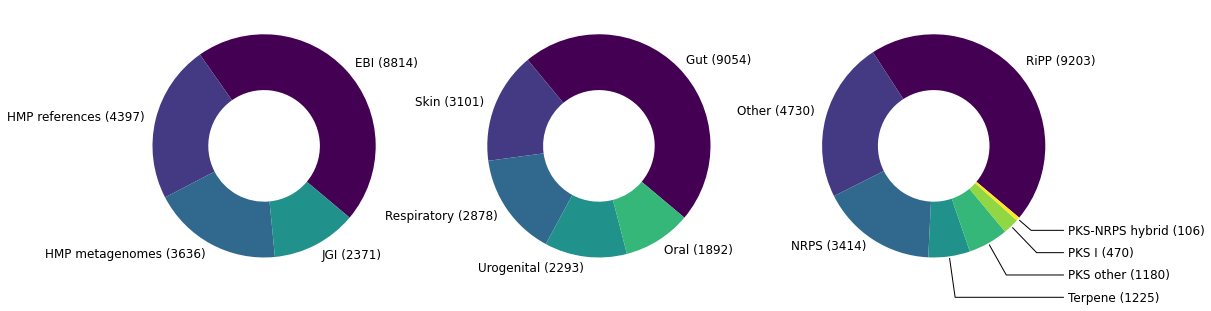

In [8]:
fig, ax = plt.subplots(1,3, figsize=(17, 6), subplot_kw=dict(aspect="equal"))
hfont = {'fontname':'DejaVu Sans', 'fontsize': 12}

colors = plt.get_cmap('viridis')(np.linspace(0, 1, 7))

counts = df_humi['Source'].value_counts()
labels = [f'{name} ({cnt})' for name, cnt in counts.iteritems()]
wedges, texts = ax[0].pie(counts, wedgeprops=dict(width=0.5), startangle=-40, labels=labels, colors=colors)
for t in texts:
    t.set_fontsize(12)
    t.set_fontname('DejaVu Sans')


counts = df_humi['Body_site'].value_counts()
labels = [f'{name} ({cnt})' for name, cnt in counts.iteritems()]
wedges, texts = ax[1].pie(counts, wedgeprops=dict(width=0.5), startangle=-40, labels=labels, colors=colors)
for t in texts:
    t.set_fontsize(12)
    t.set_fontname('DejaVu Sans')
    
counts = df_all['GCF_Type'].value_counts()
labels = [f'{name} ({cnt})' for name, cnt in counts.iteritems()]
wedges, texts = ax[2].pie(counts, wedgeprops=dict(width=0.5), startangle=-40, colors=colors)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"))

xs = []
ys = []
angs = []
for i, p in enumerate(wedges):
    
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    angs.append(ang)
    ys.append(np.sin(np.deg2rad(ang)))
    xs.append(np.cos(np.deg2rad(ang)))
    
for i, p in enumerate(wedges):
    kw2 = {**kw}
    x = xs[i]
    y = ys[i]
    ang = angs[i]
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    print(i, labels[i], horizontalalignment, ang, x, y)
    if i > 2:
        kw2 = {**kw}
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw2["arrowprops"].update({"connectionstyle": connectionstyle})
        ax[2].annotate(labels[i], xy=(x, y), xytext=(1.2*np.sign(x), 1.2*ys[3] + (i-4)*.2),
                    horizontalalignment=horizontalalignment, **kw2, **hfont)
    else:
        ax[2].annotate(labels[i], xy=(x, y), xytext=(1.1*x, 1.1*y),
                    horizontalalignment=horizontalalignment, **hfont)

## Hists

In [9]:
body_sites = sorted(df_all['Body_site'].unique())

In [10]:
gcc_sites = defaultdict(list)
bgc_gcc_sites = defaultdict(set)

for gcc, gr in df_all.groupby('GCC_ID'):
    sites = tuple(sorted(gr['Body_site'].unique()))
    bgcs = set(gr['BGC_ID'])
    if len(sites) > 1:
        gcc_sites[sites].append(gcc)
        bgc_gcc_sites[sites] |= bgcs
    

In [11]:
gcf_sites = defaultdict(list)
bgc_gcf_sites = defaultdict(set)

for gcf, gr in df_all.groupby('GCF_ID'):
    sites = tuple(sorted(gr['Body_site'].unique()))
    bgcs = set(gr['BGC_ID'])
    if len(sites) > 1:
        gcf_sites[sites].append(gcf)
        bgc_gcf_sites[sites] |= bgcs
    

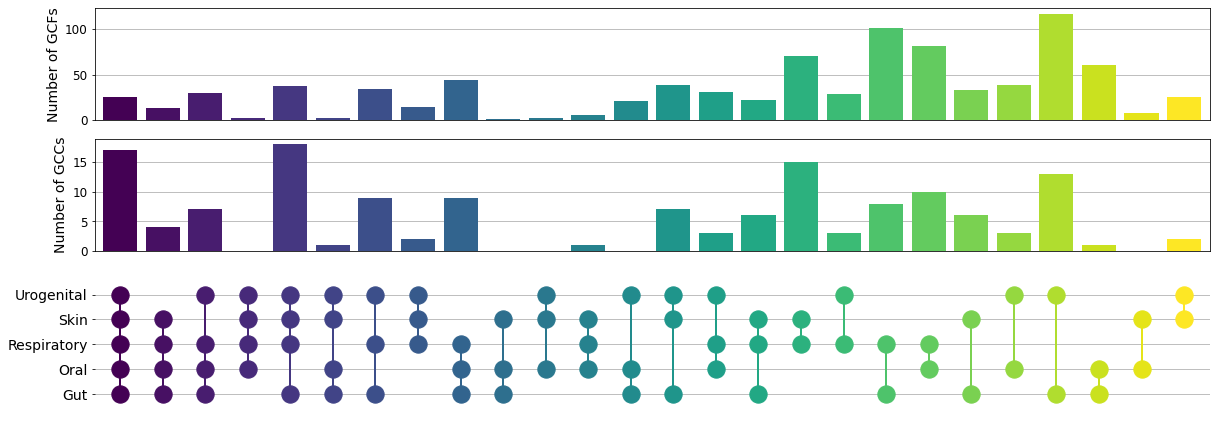

In [12]:
keys = sorted(
    set(gcc_sites.keys()) | set(gcf_sites.keys()), 
    key=len, reverse=True)
counts = np.array([len(gcc_sites[k]) for k in keys])
counts_gcf = np.array([len(gcf_sites[k]) for k in keys])

fig, (axb, axc,  axl) = plt.subplots(3,1, figsize=(17, 6), sharex=True, gridspec_kw={'height_ratios': [1.5,1.5,2]})

colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(keys)))

_ = axc.bar(np.arange(len(keys)), counts, color=colors)
_ = axb.bar(np.arange(len(keys)), counts_gcf, color=colors)

_ = axb.set_ylabel('Number of GCFs', fontsize=14)
_ = axc.set_ylabel('Number of GCCs', fontsize=14)
_ = axb.yaxis.set_tick_params(labelsize=12)
_ = axc.yaxis.set_tick_params(labelsize=12)

for ax in [axb, axc]:
    _ = ax.set_axisbelow(True)
    _ = ax.grid(axis='y')

_ = axl.set_yticks(np.arange(len(body_sites)), labels=body_sites, fontname='DejaVu Sans', fontsize=14)
_ = axl.set_ylim((-1, 5))

off = .6
_ = axl.set_xlim((-off, len(keys)-1+off))
_ = axl.grid(axis='y')
_ = axl.set_axisbelow(True)

axl.spines['top'].set_visible(False)
axl.spines['right'].set_visible(False)
axl.spines['bottom'].set_visible(False)
axl.spines['left'].set_visible(False)
_ = axl.get_xaxis().set_ticks([])

site_to_y = {s: i for i, s in enumerate(body_sites)}
for x, k in enumerate(keys):
    ys = [site_to_y[s] for s in k]
    for s in k:
        _ = axl.vlines(x, ymin=min(ys), ymax=max(ys), color=colors[x], lw=2)
        _ = axl.scatter([x], [site_to_y[s]], s=300, color=colors[x])


_ = plt.tight_layout()